<a href="https://colab.research.google.com/github/AfekIlayAdler/UNI-2020-DeepLearning/blob/master/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW2
### Or Wolkimir (308402163) and Afek Adler (204249239) 
This is our solution for applying 2 different architectures of LSTM and GRU for sequence2sequence task.
All configurations can be changed in the **config** section. There is no reason to manipulate other code sections.

For implementing different architectures we used pytorch build-in **nn.ModuleDict**.

**For the ease of convience for the checker, we leave the code with default args that make the model run for short time (40 epochs, with uploading weights at each epoch). Should be around 90 Seconds.** if you wish to make it shorter you can decrease the number of epochs .

The code Was written in this fashion in order to be **easily modified and extended** (more complicated scinerios) so maybe it appears to have some code overhead.

We added our graphs (for ~40 epochs and detailed explanations in the attached pdf).

In [0]:
import numpy as np
!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab
import torch
from torchvision import datasets, transforms
import helper
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import summary
import datetime
import pandas as pd
from collections import OrderedDict
from os import mkdir
from os.path import isdir
from glob import glob
from pathlib import Path
import nltk
from nltk import word_tokenize
import re
import pandas as pd    
from torch.autograd import Variable
from collections import Counter

# 1.Mount


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# 2.Default Config




In [0]:
from pathlib import Path
# IO
ROOT_PATH =  Path('/content/drive/My Drive/university/projects/DL/HW2/ex2_204249239_308402163/')
TRAIN_PATH =  ROOT_PATH/'PTB/ptb.train.txt'
VALID_PATH =  ROOT_PATH/'PTB/ptb.valid.txt'
TEST_PATH =  ROOT_PATH/'PTB/ptb.test.txt'

# 3. IO

In [0]:
with open(TRAIN_PATH, 'r') as train_loader:
    train = train_loader.read()
with open(VALID_PATH, 'r') as validation_loader:
    validation = validation_loader.read()
with open(TEST_PATH, 'r') as test_loader:
    test = test_loader.read()
  

# 4. Preprocessing

In [0]:
def words_to_int(l, translator):
  return   [translator[w] for w in l if w != " "]

counts = Counter(train.split())
words = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(words, 1)}
int_to_vocab = {i: v for i,v in vocab_to_int.items()}
train = np.array(words_to_int(train.split(), vocab_to_int))
validation = np.array(words_to_int(validation.split(), vocab_to_int))
test = np.array(words_to_int(test.split(), vocab_to_int))


## 4.3 get batches

In [0]:
def get_batches(arr,batch_size = 20, seq_length = 20):
    batch_size_total = batch_size * seq_length
    n_batches = (len(arr)-1) // batch_size_total
    x , y =  arr[:-1], arr[1:]
    x = x[:n_batches * batch_size_total]
    y = y[:n_batches * batch_size_total]
    x = x.reshape((batch_size, -1))
    y = y.reshape((batch_size, -1))
    for n in range(0, x.shape[1], seq_length):
      yield x[:, n:n + seq_length],y[:, n:n + seq_length]

# 5. Model


In [0]:
class RNN(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.cell_type = config.cell_type
    self.n_recurrent_layers = config.n_recurrent_layers
    vocab_size, word_embedding_dim = 10000 ,config.word_embedding_dim
    self.rnn_embedding_dim =  config.rnn_embedding_dim
    self.dropout_rate= config.dropout_rate
    self.embeddings = nn.Embedding(vocab_size, word_embedding_dim)
    self.rnn = self.get_memory_cell_type(word_embedding_dim,self.rnn_embedding_dim,self.n_recurrent_layers)
    self.fc = nn.Linear(self.rnn_embedding_dim, vocab_size) 
    self.regulizer = self.get_regulizer(config.apply_dropout,self.rnn_embedding_dim)


  def forward(self, x, hidden):
    embeds = self.embeddings(x)
    r_output, hidden = self.rnn(embeds, hidden)
    out = self.regulizer(r_output) 
    out = out.contiguous().view(-1, self.rnn_embedding_dim)
    out = self.fc(out)
    return out, hidden

  def get_regulizer(self,regulizer,hidden_layer_size):
    regulizer = 'dropout' if regulizer == True else 'no_regulizer'
    regulizers = nn.ModuleDict([
                ['dropout', nn.Dropout(self.dropout_rate)],
                ['no_regulizer', nn.Identity(hidden_layer_size)]])
    return regulizers[regulizer]

  def get_memory_cell_type(self,in_dim, out_dim,num_layers):
    memory_cells = nn.ModuleDict([
                ['GRU', nn.GRU(in_dim, out_dim, self.n_recurrent_layers,batch_first=True,dropout=self.dropout_rate)],
                ['LSTM', nn.LSTM(in_dim, out_dim, self.n_recurrent_layers,batch_first=True,dropout=self.dropout_rate)]])
    return memory_cells[self.cell_type]

  def init_hidden(self, batch_size, device):
    weight = next(self.parameters()).data # understand what is it
    if self.cell_type =='GRU':
      return weight.new(self.n_recurrent_layers, batch_size, self.rnn_embedding_dim).zero_().to(device)
    else: #LSTM
      return (weight.new(self.n_recurrent_layers, batch_size, self.rnn_embedding_dim).zero_().to(device),
          weight.new(self.n_recurrent_layers, batch_size, self.rnn_embedding_dim).zero_().to(device))


# 4. Trainer

In [0]:
class Trainer:
  def __init__(self,config):
    self.model = RNN(config)
    self.model_name = config.exp_name
    self.seed = config.seed
    self.lr = config.lr
    self.epochs = config.epochs
    self.save_model = config.save_model
    self.batch_size = config.batch_size
    self.upload_model = config.upload_model
    self.model_weights_path = config.model_weights_path
    self.sequence_len = config.sequence_len
    self.weight_decay = config.weight_decay
    self.optimizer =  optim.SGD(self.model.parameters(), lr = self.lr, momentum=0.92, nesterov=False, weight_decay= self.weight_decay)
    torch.manual_seed(self.seed)
    self.criterion = nn.CrossEntropyLoss()
    self.results = {}
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.clip = 5
    if torch.cuda.is_available():
      self.model.to(self.device)

  def get_results(self):
    return pd.DataFrame.from_dict(self.results)

  def record(self,epoch,**kwargs):
    epoch = "{:02d}".format(epoch)
    temp = f"| epoch   # {epoch} :"
    for key, value in kwargs.items():
      key = f"{self.model_name}_{key}"
      if not self.results.get(key):
        self.results[key] =[]
      self.results[key].append(value)
      val = '{:.2f}'.format(np.round(value,2))
      temp += f"{key} : {val}      |       "
      
    print(temp)

  def lr_scheduler(self,epoch):
    if 25 > epoch >= 4:
      self.lr *= 0.9
    if epoch ==25:
      self.lr *= 0.1
    if epoch > 25:
      self.lr *= 0.7      

  def fit(self,train,validation,test, exp_name): 
    train_accu, test_accu = [],[]
    for epoch in range(1,self.epochs+1):
      self.lr_scheduler(epoch)
      weights_path = Path(f"{self.model_weights_path}/{self.model_name}_{epoch}.pth")
      if weights_path.exists() and self.upload_model:
        epoch_train_loss = self.load_checkpoint(weights_path,epoch)
      else:
        epoch_train_loss = self.run_epoch(train)
      epoch_test_loss = self.test(validation)
      self.record(epoch,train_loss = epoch_train_loss, validation_loss = epoch_test_loss)
      self.save_checkpoint(weights_path,epoch_train_loss)
    test_loss = self.test(test)
    padding = '*'*40
    print(f"{padding} TEST LOSS : {test_loss} {padding}")

  def get_hidden_no_grad(self,h):
      if self.model.cell_type == 'GRU':
        h = h.data
      else:
        h = tuple([each.data for each in h])
      return h


  def run_epoch(self,data):
    train_loss , counter = 0 , 0
    self.model.train()
    h = self.model.init_hidden(self.batch_size,self.device)
    for i, (x, y) in enumerate(get_batches(data, self.batch_size,self.sequence_len)):
      inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
      inputs = inputs.to(self.device)
      targets = targets.to(self.device, dtype=torch.int64)
      h = self.get_hidden_no_grad(h)
      self.optimizer.zero_grad()
      output, h = self.model(inputs, h)
      loss = self.criterion(output, targets.reshape(-1))
      loss.backward()
      nn.utils.clip_grad_norm_(self.model.parameters(), self.clip)
      self.optimizer.step()
      train_loss += loss.item()
      counter += 1
    perplexity = np.exp(train_loss/counter)
    return perplexity

  def test(self,data):
    self.model.eval()
    test_loss, counter = 0, 0
    with torch.no_grad():
      h = self.model.init_hidden(self.batch_size,self.device)
      for x,y in get_batches(data, self.batch_size,self.sequence_len):
        inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
        inputs = inputs.to(self.device)
        targets = targets.to(self.device, dtype=torch.int64)
        h = self.get_hidden_no_grad(h)
        output, h = self.model(inputs, h)
        loss = self.criterion(output, targets.reshape(-1).long())
        test_loss += loss.item()
        counter += 1
      perplexity = np.exp(test_loss/counter)
      return perplexity
    

  def save_checkpoint(self,weights_path,loss):
    if (not weights_path.exists()) and self.save_model: 
      torch.save({'model_state_dict': self.model.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),'loss': loss}, weights_path)
      
  def load_checkpoint(self,weights_path,epoch):
    checkpoint = torch.load(weights_path)
    self.model.load_state_dict(checkpoint['model_state_dict'])
    self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    self.model.to(self.device)
    loss = checkpoint['loss']
    print(f"Uploaded weights succesfuly at epoch number {epoch}")
    return loss

# 5. Utils
Utility functions for the code

In [0]:
class Config:  
  def __init__(self, **kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)

  def add_attributes(self,**kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)

def create_directories(l):
  for directory_path in l:
    if not (isdir(directory_path)):
      mkdir(directory_path)

# 5. experiments Config 

In [0]:
# NEURAL NET
MODEL_WEIGHTS_DIR = 'model_weights'
GRAPHS_FOLDER_NAME = 'graphs'
model_weights_dir = ROOT_PATH/MODEL_WEIGHTS_DIR 
graphs_dir = ROOT_PATH/GRAPHS_FOLDER_NAME 
SAVE_FIGS = True

def get_base_config():
  ####################################################################
  # model consistency options
  SAVE_TO_CHECKPOINTS = True # if ture, saves model.name_epcoch file into the weights folder
  LOAD_CHECKPOINTS = False # # if ture, every epoch tries to load pretrained weights
  ####################################################################
  # if needed, can be modified to upload the 'best model'

  return Config(
          seed = 42, lr = 0.2,epochs = 40,sequence_len = 20,
          batch_size = 20, weight_decay = 0.00004,dropout_rate = 0.25,
          n_recurrent_layers = 2, word_embedding_dim =200, rnn_embedding_dim = 200,
          save_model = SAVE_TO_CHECKPOINTS,
          upload_model = LOAD_CHECKPOINTS,
          model_weights_path = model_weights_dir)

EXPERIMENTS =  {'lstm_with_dropout':('LSTM',True),'gru_with_dropout':('GRU',True), 'lstm_no_dropout': ('LSTM',False),'gru_no_dropout':('GRU',False)}

# 7. Run experiments

In [0]:
def run_exp(experiments):
  # create weights directory
  create_directories([graphs_dir,model_weights_dir])
  results = []
  for exp_name,(cell_type , apply_dropout) in experiments.items():
    print(f"{'#'*118} \n running {exp_name} experiment\n{'#'*118}") 
    config.add_attributes(exp_name = exp_name, apply_dropout = apply_dropout, cell_type = cell_type)
    trainer = Trainer(config)
    trainer.fit(train,validation,test,exp_name)
    results.append(trainer.get_results())
  return results

config = get_base_config()
results = run_exp(EXPERIMENTS)

###################################################################################################################### 
 running lstm_with_dropout experiment
######################################################################################################################
| epoch   # 01 :lstm_with_dropout_train_loss : 460.18      |       lstm_with_dropout_validation_loss : 301.36      |       
| epoch   # 02 :lstm_with_dropout_train_loss : 277.01      |       lstm_with_dropout_validation_loss : 242.51      |       
| epoch   # 03 :lstm_with_dropout_train_loss : 231.69      |       lstm_with_dropout_validation_loss : 216.34      |       
| epoch   # 04 :lstm_with_dropout_train_loss : 207.63      |       lstm_with_dropout_validation_loss : 199.33      |       
| epoch   # 05 :lstm_with_dropout_train_loss : 192.20      |       lstm_with_dropout_validation_loss : 191.26      |       
| epoch   # 06 :lstm_with_dropout_train_loss : 180.54      |       lstm_with_dropout_validation_loss : 

# 7. Visualizing the results

In [0]:
output = pd.concat(results,sort=False,axis=1).tail(1).T

In [0]:
output

,39
lstm_with_dropout_train_loss,104.233835
lstm_with_dropout_validation_loss,137.993978
gru_with_dropout_train_loss,93.106490
gru_with_dropout_validation_loss,138.752922
lstm_no_dropout_train_loss,84.980085
lstm_no_dropout_validation_loss,142.014916
gru_no_dropout_train_loss,70.897678
gru_no_dropout_validation_loss,148.859692


<Figure size 432x288 with 0 Axes>

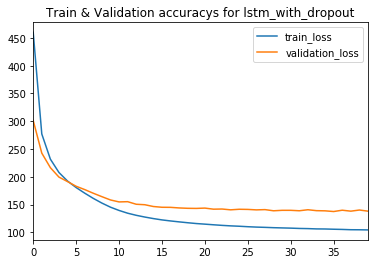

<Figure size 432x288 with 0 Axes>

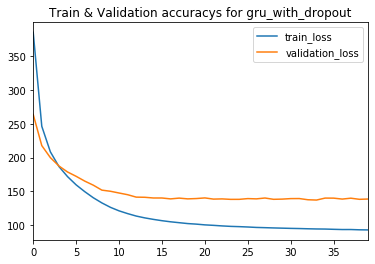

<Figure size 432x288 with 0 Axes>

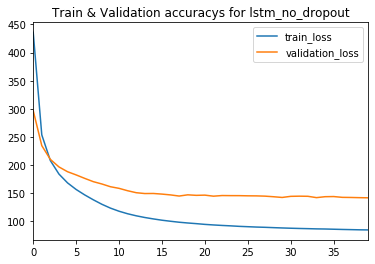

<Figure size 432x288 with 0 Axes>

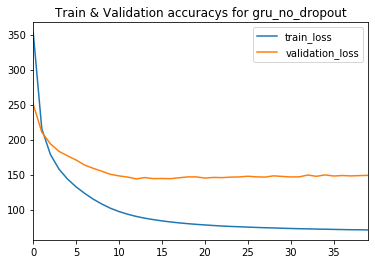

In [0]:
results_df = pd.concat(results,axis = 1)
for exp in EXPERIMENTS:
  suffixes =  ['train_loss','validation_loss']
  cols = [f"{exp}_{suffix}" for suffix in suffixes]
  temp_df = results_df[cols]
  temp_df.columns =  suffixes 
  plt.figure()
  temp_df.astype(float).plot(title= F"Train & Validation accuracys for {exp}")
  if SAVE_FIGS:
    file_name = F"{exp}.png"
    plt.savefig(graphs_dir / file_name)